In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
df = pd.read_csv('covid.csv')
df

,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.000000,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.000000,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.000000,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.000000,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.000000,0.038426,0.003435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,United States,United States,0,2022-05-09,2022-05-15,7,2022,19,336997624,57864.0,1868,55510.914407,2353.085593,55996.0,0.554307,0.698250,0.042390
5766,United States,United States,0,2022-05-16,2022-05-22,7,2022,20,336997624,57523.0,2461,54958.314407,2564.685593,55062.0,0.730272,0.761040,0.046666
5767,United States,United States,0,2022-05-23,2022-05-29,7,2022,21,336997624,56959.0,2607,54850.514407,2108.485593,54352.0,0.773596,0.625668,0.038441
5768,United States,United States,0,2022-05-30,2022-06-05,7,2022,22,336997624,57545.0,1956,54459.714407,3085.285593,55589.0,0.580420,0.915521,0.056653


In [27]:
df = df.dropna()
if not df['start_date'].is_monotonic_increasing:
    df = df.sort_values(by='start_date')

# Выбор региона с большим количеством данных, например США
selected_region = 'United States'
region_df = df[df['region'] == selected_region].copy()

# Удаление столбца 'total_deaths'
region_df = region_df.drop(columns=['total_deaths'])

In [28]:
region_df['days_since_start'] = (region_df['start_date'] - region_df['start_date'].min()).dt.days
region_df['covid_deaths_per_100k_rolling_7'] = region_df['covid_deaths_per_100k'].rolling(window=7).mean()
region_df['covid_deaths_per_100k_lag_1'] = region_df['covid_deaths_per_100k'].shift(1)
region_df = region_df.dropna()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
X = region_df[['week', 'days_since_start', 'covid_deaths_per_100k_rolling_7', 'covid_deaths_per_100k_lag_1']]
y = region_df['covid_deaths_per_100k']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Градиентный бустинг
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

# Кросс-валидация для градиентного бустинга
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_gb = cross_val_score(model_gb, X, y, cv=tscv, scoring='r2')
print(f'Cross-Validation R2 Scores for Gradient Boosting: {cv_scores_gb}')
print(f'Mean Cross-Validation R2 Score for Gradient Boosting: {cv_scores_gb.mean()}')

In [ ]:
y_pred_gb = model_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'R² Score for Gradient Boosting on Test Data: {r2_gb}')

In [ ]:
# Визуализация важности признаков для градиентного бустинга
plt.figure(figsize=(12, 6))
plt.barh(X.columns, model_gb.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения')
plt.plot(y_test.index, y_pred_gb, label='Прогноз (Gradient Boosting)', color='red')
plt.legend()
plt.title(f'Прогноз смертности от COVID-19 на 100k для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()

Модель градиентного бустинга показывает лучшие результаты на тестовой выборке по сравнению с моделью Arima.
ARIMA модель показывает низкое качество предсказаний, с отрицательными значениями как на кросс-валидации, так и на тестовой выборке, в то время как модель градиентного бустинга справляется хорошо

In [30]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
cv_scores_lr = cross_val_score(model_lr, X, y, cv=tscv, scoring='r2')
print(f'Cross-Validation R2 Scores for Linear Regression: {cv_scores_lr}')
print(f'Mean Cross-Validation R2 Score for Linear Regression: {cv_scores_lr.mean()}')

Cross-Validation R2 Scores for Linear Regression: [-24.1792942    0.49321928  -1.03955846   0.73766872  -0.60134816]
Mean Cross-Validation R2 Score for Linear Regression: -4.917862564895541


In [31]:
y_pred_lr = model_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
print(f'R2 Score for Linear Regression on Test Data: {r2_lr}')

R2 Score for Linear Regression on Test Data: 0.4224914239676021


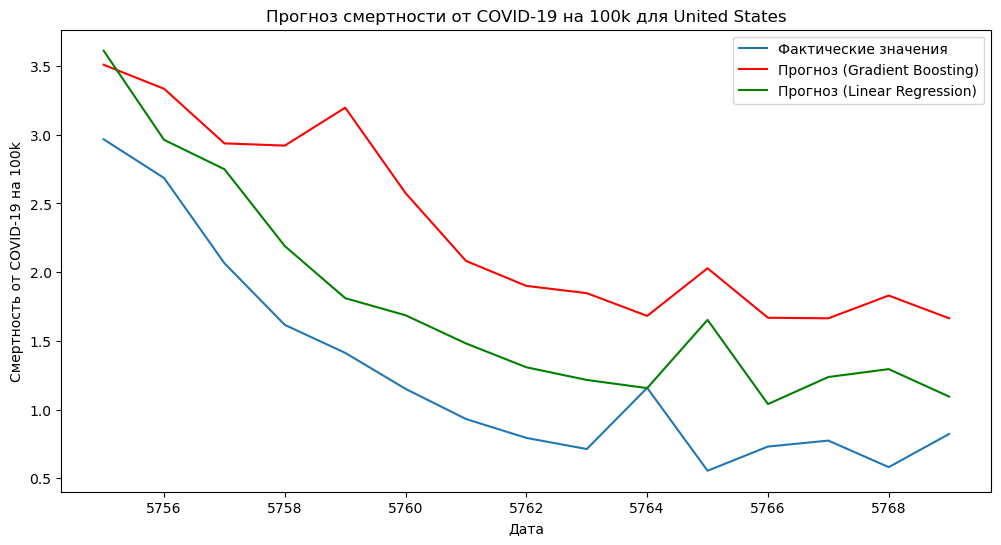

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения')
plt.plot(y_test.index, y_pred_gb, label='Прогноз (Gradient Boosting)', color='red')
plt.plot(y_test.index, y_pred_lr, label='Прогноз (Linear Regression)', color='green')
plt.legend()
plt.title(f'Прогноз смертности от COVID-19 на 100k для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()